# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

# Read Data

In [2]:
gait_df = pd.read_csv("gait.csv")
gait_df.head()

,subject,condition,replication,leg,joint,time,angle
0,1,1,1,1,1,0,4.682881
1,1,1,1,1,1,1,5.073127
2,1,1,1,1,1,2,5.229774
3,1,1,1,1,1,3,5.083273
4,1,1,1,1,1,4,4.652399


# Get foreground and background data

In [3]:
def get_angle_displacements(df, condition, joint):
    filtered_df = df[(df['condition'] == condition) & (df['joint'] == joint)]
    series_list = filtered_df.groupby(['subject', 'replication', 'leg'])['angle'].apply(list).tolist()
    return series_list

# Apply the function for condition 1 and 3 with joint=2
background = get_angle_displacements(gait_df, 1,2)
foreground = get_angle_displacements(gait_df, 3,2)


def get_legs(df, condition, joint):
    filtered_df = df[(df['condition'] == condition) & (df['joint'] == joint)]
    legs = filtered_df.groupby(['subject', 'replication', 'leg'])['leg'].first().tolist()
    return legs

background_leg = get_legs(gait_df, 1, 2)
foreground_leg = get_legs(gait_df, 3, 2)

# Figure 4b

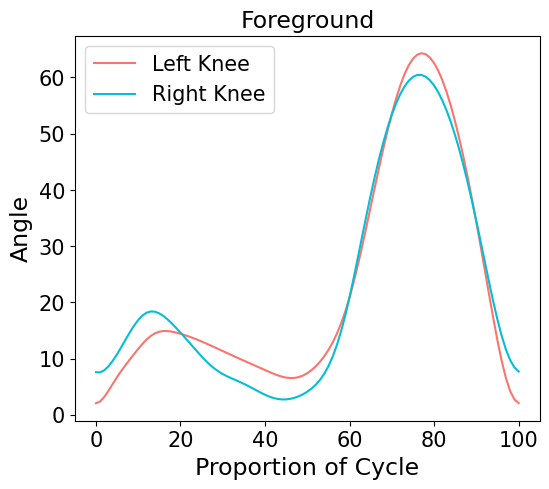

In [19]:
def plot_angle_mean(angle_series_list, legs, title="Angle Series by Leg"):
    leg_colors = {1: '#F9756E', 2: '#04BED5'}
    leg_descriptions = {1: 'Left Knee', 2: 'Right Knee'}
    
    plt.figure(figsize=(6, 5))
    
    left_knee_angles = []
    right_knee_angles = []

    for series, leg in zip(angle_series_list, legs):
        if leg == 1:
            left_knee_angles.append(series)
        elif leg == 2:
            right_knee_angles.append(series)
    
    # Plot mean angle for left knee
    if left_knee_angles:
        left_mean = np.mean(left_knee_angles, axis=0)
        plt.plot(left_mean, color=leg_colors[1], label=leg_descriptions[1])

    # Plot mean angle for right knee
    if right_knee_angles:
        right_mean = np.mean(right_knee_angles, axis=0)
        plt.plot(right_mean, color=leg_colors[2], label=leg_descriptions[2])
    
    plt.xlabel("Proportion of Cycle", fontsize=17)
    plt.ylabel("Angle", fontsize=17)
    plt.legend(fontsize=15)
    plt.title(label=title, fontsize=17)
    plt.tick_params(axis='x', labelsize=15)  
    plt.tick_params(axis='y', labelsize=15)  

    plt.show()


plot_angle_mean(foreground, foreground_leg, "Foreground")

# Figure 4d

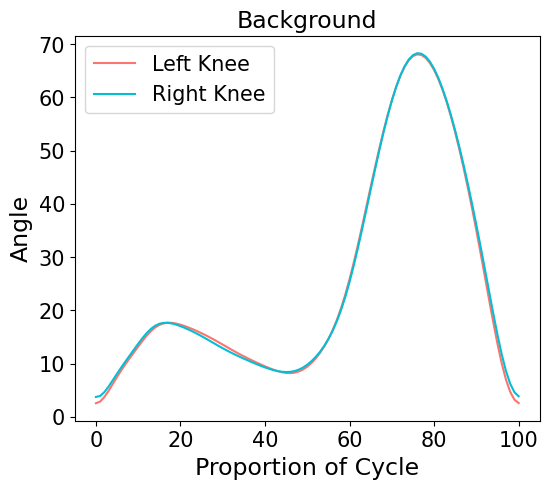

In [21]:
plot_angle_mean(background, background_leg, "Background")


In [22]:
def center_time_series(data_list):
    data_array = np.array(data_list)
    means = np.mean(data_array, axis=0)
    centered_data = (data_array - means) 
    centered_data = centered_data.tolist()

    return centered_data


standardized_brace_list = center_time_series(foreground)
standardized_normal_list = center_time_series(background)

# Figure 4f

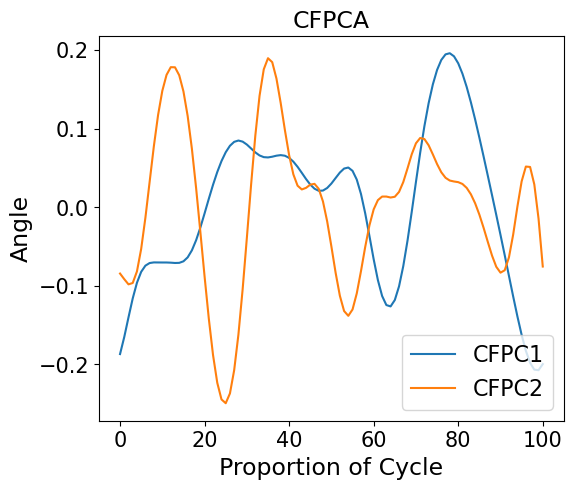

In [23]:
#----- the file "main.py" contains the CFPCA method, as well as other miscellaneous function ----
#----- Currently, we change directories to access the parent directory, where the main file is located ----

import os

os.chdir('..')
from main import *

#---- os.chdir('..') goes back to the parent directory, if main.py is in the same folder as this file, it can be omitted ---

t = np.linspace(0, 100, 101)

components = CFPCA(standardized_brace_list,standardized_normal_list,5,t,True,True)[0]
fpca_foreground = CFPCA(standardized_brace_list,standardized_normal_list,0,t, True, True)[0]
fpca_foreground_background = CFPCA(standardized_brace_list+standardized_normal_list,standardized_normal_list,0,t, True, True)[0]


plt.figure(figsize=(6, 5))
plt.xlabel("Proportion of Cycle", fontsize = 17)
plt.ylabel("Angle", fontsize = 17)
plt.plot(t, components[:,0])
plt.plot(t, components[:,1])
plt.legend(['CFPC1', 'CFPC2'], fontsize = 16, loc = 'lower right')
plt.title("CFPCA", fontsize = 17)
plt.tick_params(axis='x', labelsize=15)  
plt.tick_params(axis='y', labelsize=15)  

# Appendix - Figure 10a

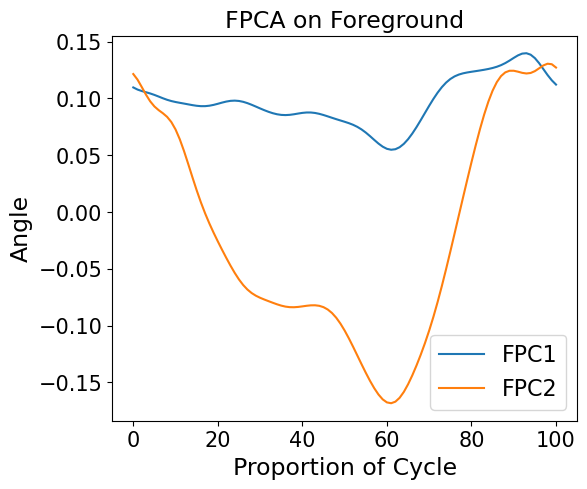

In [16]:
plt.figure(figsize=(6, 5))
plt.xlabel("Proportion of Cycle", fontsize = 17)
plt.ylabel("Angle", fontsize = 17)
plt.plot(t, fpca_foreground[:,0])
plt.plot(t, fpca_foreground[:,1])
plt.legend(['FPC1', 'FPC2'], fontsize = 16, loc = 'lower right')
plt.title("FPCA on Foreground", fontsize = 17)
plt.tick_params(axis='x', labelsize=15)  
plt.tick_params(axis='y', labelsize=15)  

# Appendix - Figure 10b

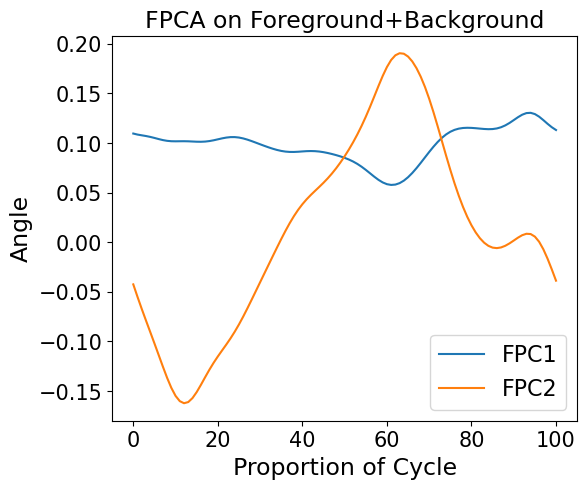

In [15]:
plt.figure(figsize=(6, 5))
plt.xlabel("Proportion of Cycle", fontsize = 17)
plt.ylabel("Angle", fontsize = 17)
plt.plot(t, fpca_foreground_background[:,0])
plt.plot(t, fpca_foreground_background[:,1])
plt.legend(['FPC1', 'FPC2'], fontsize = 16, loc = 'lower right')
plt.title("FPCA on Foreground+Background", fontsize = 17)
plt.tick_params(axis='x', labelsize=15)  
plt.tick_params(axis='y', labelsize=15)  

In [10]:
# ---------- CALCULATE SCORES ------------------

unique_pc_score1 = calculate_scores(standardized_brace_list, components[:,0])
unique_pc_score2 = calculate_scores(standardized_brace_list, components[:,1])

fpc_1_foreground = calculate_scores(standardized_brace_list, fpca_foreground[:,0])
fpc_2_foreground = calculate_scores(standardized_brace_list, fpca_foreground[:,1])

fpc_1_foreground_background = calculate_scores(standardized_brace_list, fpca_foreground_background[:,0])
fpc_2_foreground_background = calculate_scores(standardized_brace_list, fpca_foreground_background[:,1])


In [11]:
# ---------- DEFINE PLOT FUNCTION ----------------

def plot_pc_scores(pc_scores1, pc_scores2, legs,title):
    plt.figure(figsize=(6, 5))  
    colors = ['#F9756E' if leg == 1 else '#04BED5' for leg in legs] 
    
    for i in range(len(pc_scores1)):
        plt.scatter(pc_scores1[i], pc_scores2[i], color=colors[i])  # Color by leg
    

    plt.title(title ,fontsize = 17)
    
    plt.scatter([], [], color='#F9756E', label='Left Knee')
    plt.scatter([], [], color='#04BED5', label='Right Knee')
    plt.legend(fontsize = 15, loc = "upper right")

    plt.tick_params(axis='x', labelsize=15)  
    plt.tick_params(axis='y', labelsize=15)  

# Figure 4a

SS: 0.06
DB: 4.13


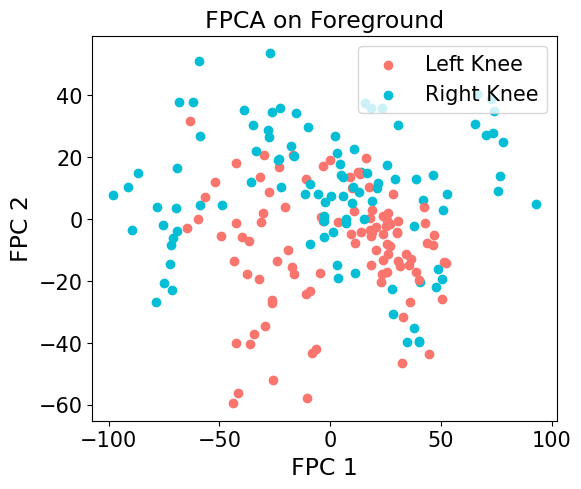

In [12]:
plot_pc_scores(fpc_1_foreground, fpc_2_foreground, foreground_leg, "FPCA on Foreground")
plt.xlabel('FPC 1', fontsize = 17)
plt.ylabel('FPC 2', fontsize = 17)

X = np.column_stack((fpc_1_foreground, fpc_2_foreground))

sil_score = np.round(silhouette_score(X, foreground_leg),2)
db_score = np.round(davies_bouldin_score(X, foreground_leg),2)

print("SS:", sil_score)
print("DB:", db_score)

# Figure 4c

SS: 0.03
DB: 5.71


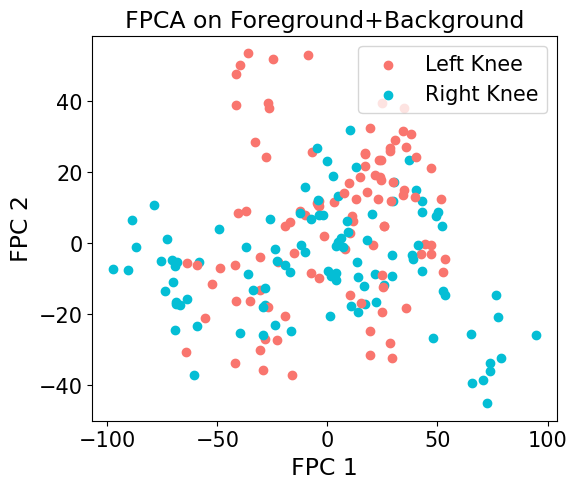

In [13]:
plot_pc_scores(fpc_1_foreground_background, fpc_2_foreground_background, foreground_leg, "FPCA on Foreground+Background")
plt.xlabel('FPC 1', fontsize = 17)
plt.ylabel('FPC 2', fontsize = 17)

X = np.column_stack((fpc_1_foreground_background, fpc_2_foreground_background))

sil_score = np.round(silhouette_score(X, foreground_leg),2)
db_score = np.round(davies_bouldin_score(X, foreground_leg),2)

print("SS:", sil_score)
print("DB:", db_score)

# Figure 4e

SS: 0.51
DB: 0.66


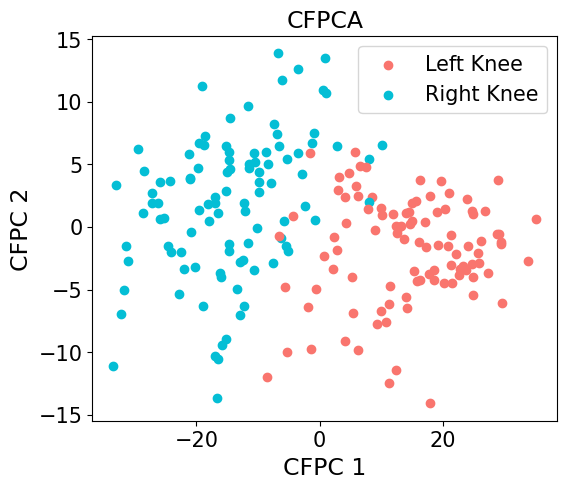

In [14]:
plot_pc_scores(unique_pc_score1, unique_pc_score2, foreground_leg, "CFPCA")
plt.xlabel('CFPC 1', fontsize = 17)
plt.ylabel('CFPC 2', fontsize = 17)

X = np.column_stack((unique_pc_score1, unique_pc_score2))

sil_score = np.round(silhouette_score(X, foreground_leg),2)
db_score = np.round(davies_bouldin_score(X, foreground_leg),2)

print("SS:", sil_score)
print("DB:", db_score)

# Appendix - Figure 9a

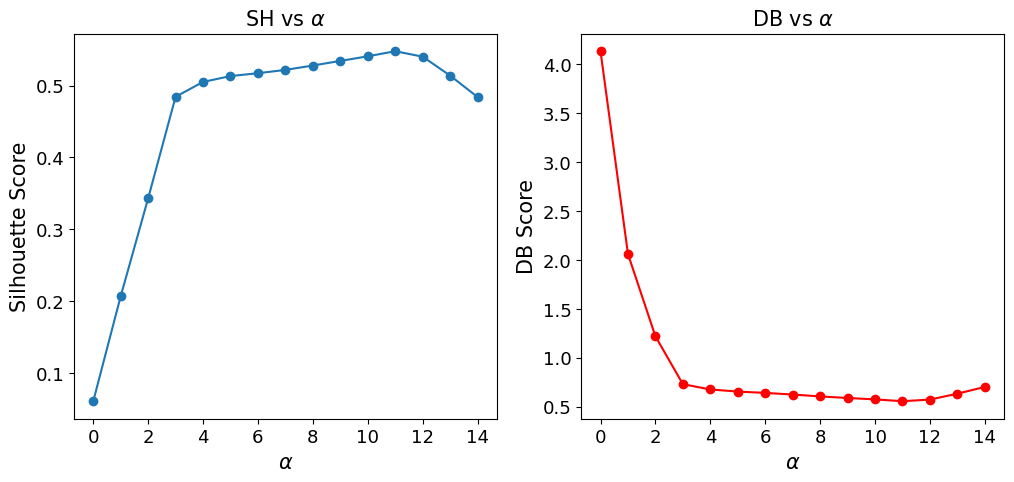

In [16]:
def compute_and_plot_components(foreground, background, alpha):
    components = CFPCA(foreground,background, alpha, t, True, True)[0]

    unique_pc_score1 = calculate_scores(foreground, components[:,0])
    unique_pc_score2 = calculate_scores(foreground, components[:,1])
    X = np.column_stack((unique_pc_score1, unique_pc_score2))

    return X

alphas = range(0, 15)
silhouette_scores = []
db_scores = []

for alpha in alphas:
    X = compute_and_plot_components(standardized_brace_list, standardized_normal_list, alpha)
    silhouette_avg = silhouette_score(X, foreground_leg)
    db_avg = davies_bouldin_score(X, foreground_leg)
    
    silhouette_scores.append(silhouette_avg)
    db_scores.append(db_avg)

# Plotting the silhouette and DB scores
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(alphas, silhouette_scores, marker='o', linestyle='-')
plt.title(r'SH vs $\alpha$', fontsize = 15)
plt.xlabel(r'$\alpha$', fontsize = 15)
plt.ylabel('Silhouette Score', fontsize = 15)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)

plt.subplot(1, 2, 2)
plt.plot(alphas, db_scores, marker='o', linestyle='-', color='r')
plt.title(r'DB vs $\alpha$', fontsize = 15)
plt.xlabel(r'$\alpha$', fontsize = 15)
plt.ylabel('DB Score', fontsize = 15)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)

plt.show();